In [1]:
from functions import *
from random import sample
import json
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import dateparser
import random
import re
from pylab import *

/home/ruben/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
base_path = "/media/ruben/Data Drive/react-data/protest/{}".format("selection2")

In [3]:
def PlotNER(ner, language, first_year,last_year,n,relative=True):
    
    print('Looking at {} in {}'.format(ner,language))
    print('{}-{}'.format(first_year,last_year))
    print('Taking the Top {} most frequent {}-entities'.format(n,ner))
    # Get Publication Dates

    dates_ref = dict()

    for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
        photo_folder = os.path.join(base_path, photo)
        with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
            x = f.readlines()
        dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})

    # Get Entities
    ner_gpe = dict()

    for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
        photo_folder = os.path.join(base_path, photo)
        fn = os.path.join(photo_folder, "entities-" + photo + ".json")
        with open(fn) as fp:
            file = json.load(fp)

        for lan,items in file.items():
            if lan not in ner_gpe.keys():
                ner_gpe.update({lan:dict()})
            for id_,entities in items.items():
                ll_entities = entities['entities']
                
                ner_entities = []
                
                for ner_item in ner:
                    tmp_ner_entities = [i[0] for i in ll_entities if i[-1] == ner_item and len(i[0]) > 2]
                    ner_entities += tmp_ner_entities
                if len(ner_entities) > 0:
                    ner_gpe[lan].update({id_:ner_entities})
    #return ner_gpe
    # Match Dates/Entities
    ner_df_dia = pd.DataFrame()
    for id_,locs in ner_gpe[language].items():

        id_ = id_.split('.html_')[-1]

        if id_ not in dates_ref.keys():
            continue

        date = dates_ref[id_][0:4]
        tmp = [[x,date,1] for x in locs]
        tmp = pd.DataFrame(tmp)
        ner_df_dia = ner_df_dia.append(tmp)
        
    ner_df_dia.columns = ['ent','year','count']
    
    ner_df_dia = ner_df_dia[ner_df_dia['ent'].isin([i[0] for i in Counter(list(ner_df_dia['ent'])).most_common(n)])]

    ner_df_dia = ner_df_dia.groupby(['ent','year']).sum().reset_index()
    ner_df_dia = ner_df_dia[(ner_df_dia['year'].astype(int) <= last_year) & (ner_df_dia['year'].astype(int) >= first_year)]
    ner_df_dia2 = ner_df_dia.pivot(index='ent',columns='year',values='count').reset_index()
    ner_df_dia2 = ner_df_dia2.fillna(0)

    if relative==True:

        for c in list(ner_df_dia2.columns)[1:]:
            sum_ = sum(ner_df_dia2[c].astype(int))
            ner_df_dia2[c] = ner_df_dia2[c] / sum_

        ner_df_dia2 = ner_df_dia2.melt(id_vars='ent')
        ner_df_dia2 = ner_df_dia2.pivot(index='year',columns='ent',values='value').reset_index()
#         p = ner_df_dia2.plot(x="year", y = list(ner_df_dia2.columns)[1:], kind="area", colormap = "tab20b", figsize=(20,10)).legend(bbox_to_anchor=(1, 1))
#         plt.title('Top {} {}-entities in {}-language webpages between {} and {}'.format(n,ner,language,first_year,last_year))
#         #plt.axis('off')
#         plt.show()
#         cmap = cm.get_cmap('tab20b', len(list(ner_df_dia2.columns)[1:]))    # PiYG
#         colors = []
#         for i in range(cmap.N):
#             rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
#             colors.append(matplotlib.colors.rgb2hex(rgb))

#         plt.figure(figsize=(20, 10))

#         for c,city in enumerate(list(ner_df_dia2.columns)[1:]):
#             plt.bar(list(ner_df_dia2['year']), list(ner_df_dia2[city]), color=colors[c])

#         plt.legend(list(ner_df_dia2.columns)[1:], loc='upper right',fontsize=13)
#         plt.title('Top {} {}-entities in {}-language webpages between {} and {}'.format(n," & ".join(ner),language,first_year,last_year))
#         plt.xticks(np.arange(len(ner_df_dia2)), ner_df_dia2['year'], rotation=90)

    if relative == False:
        ner_df_dia2 = ner_df_dia2.melt(id_vars='ent')
        ner_df_dia2 = ner_df_dia2.pivot(index='year',columns='ent',values='value').reset_index()
        #ner_df_dia2['year'] = ner_df_dia2['year'].astype(int)
#         cmap = cm.get_cmap('tab20b', len(list(ner_df_dia2.columns)[1:]))    # PiYG
#         colors = []
#         for i in range(cmap.N):
#             rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
#             colors.append(matplotlib.colors.rgb2hex(rgb))

#         plt.figure(figsize=(20, 10))

#         for c,city in enumerate(list(ner_df_dia2.columns)[1:]):
#             plt.bar(list(ner_df_dia2['year']), list(ner_df_dia2[city]), color=colors[c])

#         plt.legend(list(ner_df_dia2.columns)[1:], loc='upper right',fontsize=13)
#         plt.title('Top {} {}-entities in {}-language webpages between {} and {}'.format(n," & ".join(ner),language,first_year,last_year),size=16)
#         plt.xticks(np.arange(len(ner_df_dia2)), ner_df_dia2['year'], rotation=90)
    #fig = plt.get_figure()
    #fig.savefig('{}-{}-{}-{}-{}.png'.format("_".join(ner).lower(),language,first_year,last_year,n))
    #plt.show()
    df2 = pd.DataFrame()

    for i in list(ner_df_dia2.columns)[1:]:
        s = sum(ner_df_dia2[i])
        tmp = pd.DataFrame([i,s]).T
        df2 = df2.append(tmp)

    df2.columns = ['ent','c']
    df2 = df2.sort_values('c')
    return df2

Looking at ['LOC', 'GPE'] in en
2003-2018
Taking the Top 25 most frequent ['LOC', 'GPE']-entities
Looking at ['LOC', 'GPE'] in fr
2003-2018
Taking the Top 25 most frequent ['LOC', 'GPE']-entities
Looking at ['LOC', 'GPE'] in es
2003-2018
Taking the Top 25 most frequent ['LOC', 'GPE']-entities
Looking at ['LOC', 'GPE'] in it
2003-2018
Taking the Top 25 most frequent ['LOC', 'GPE']-entities


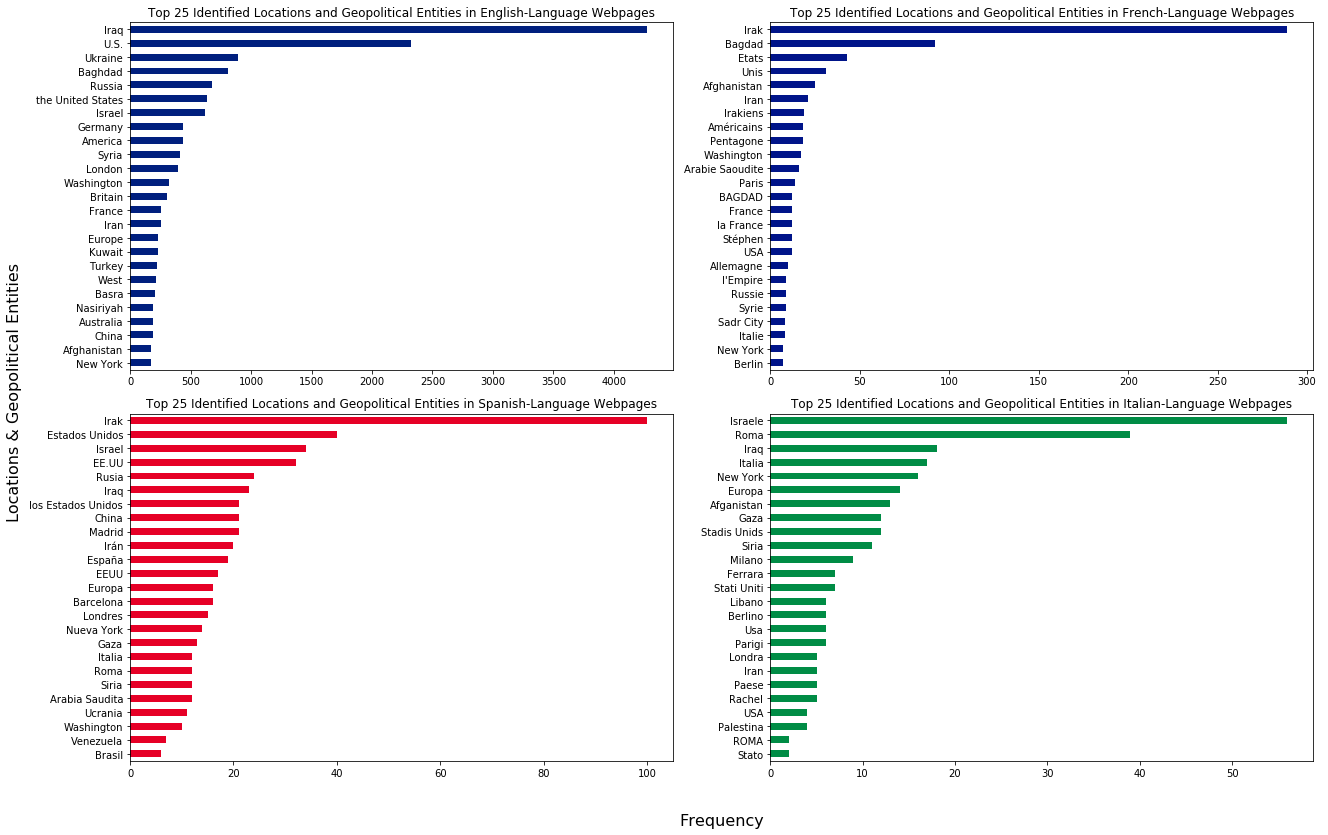

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(30,15))


df1 = PlotNER(["LOC","GPE"],"en",2003,2018,25,relative=False)
df1 = df1.plot.barh(x='ent', y='c',figsize = (20,12),legend=None,ax=axes[0,0],title="Top 25 Identified Locations and Geopolitical Entities in English-Language Webpages",color="#001F7E")
df1.set_xlabel("")
df1.set_ylabel("")


df2 = PlotNER(["LOC","GPE"],"fr",2003,2018,25,relative=False)
df2 = df2.plot.barh(x='ent', y='c',figsize = (20,12),legend=None,ax=axes[0,1],title="Top 25 Identified Locations and Geopolitical Entities in French-Language Webpages",color="#001489")
df2.set_xlabel("")
df2.set_ylabel("")

df3 = PlotNER(["LOC","GPE"],"es",2003,2018,25,relative=False)
df3 = df3.plot.barh(x='ent', y='c',figsize = (20,12),legend=None,ax=axes[1,0],title="Top 25 Identified Locations and Geopolitical Entities in Spanish-Language Webpages",color="#e60026")
df3.set_xlabel("")
df3.set_ylabel("")

df4 = PlotNER(["LOC","GPE"],"it",2003,2018,25,relative=False)
df4 = df4.plot.barh(x='ent', y='c',figsize = (20,12),legend=None,ax=axes[1,1],title="Top 25 Identified Locations and Geopolitical Entities in Italian-Language Webpages",color="#008C45")
df4.set_xlabel("")
df4.set_ylabel("")

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Frequency",labelpad=35,fontsize= 16)
plt.ylabel("Locations & Geopolitical Entities",labelpad=85,fontsize= 16)
fig.tight_layout()

fig.savefig('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/images_tables_article_2/ner-locations-en-fr-es-it.png',dpi=600)

In [69]:
def NERContext(language,word,window):
    print('Contextualizing {} in {}'.format(word,language))
    d = []
    for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
        photo_folder = os.path.join(base_path, photo)
        fn = os.path.join(photo_folder, "entities-" + photo + ".json")
        with open(fn) as fp:
            file = json.load(fp)

        for lan,items in file.items():

            for id_,items2 in items.items():
                text = items2['text']
                url = id_.split("html_")[1]
                
                if url in dates_ref.keys():
                    date = dates_ref[url]
                else:
                    date = "unknown date"

                if len([i for i in items2['entities'] if i[0] == word]) != 0:
                    for i in [i for i in items2['entities'] if i[0] == word]:
                        w = text[i[1]-window:i[2]+window]
                        d.append([url,date,w])
    print('Year Frequencies top 5:', " | ".join([k+": "+str(v) for k,v in dict(Counter([i[1][0:4] for i in d if i[1] != "unknown date"]).most_common(5)).items()]))               
    d = pd.DataFrame(d,columns = ['url','date','window'])
    return d

In [72]:
df = NERContext('it','Israele',35)

Contextualizing Israele in it
Year Frequencies top 5: 2006: 54 | 2020: 6 | 2003: 2


In [73]:
df.to_csv('/media/ruben/FEF44259F44213F5/Users/Ruben/Documents/GitHub/ReACT_GCV/data/context-Israele-it.csv',index=False)

In [38]:
dates_ref = dict()

for photo in [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]:
    photo_folder = os.path.join(base_path, photo)
    with open(os.path.join(photo_folder,"dates.txt"),'r') as f:
        x = f.readlines()
    dates_ref.update({d.split('|')[0]:d.split('|')[-1].replace('\n','') for d in x if d.split('|')[-1].replace('\n','') != "na" and "ERROR" not in d.split('|')[-1].replace('\n','')})